In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import bandpass_filter
plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

# load the model and dset

In [2]:
im_torch, im_orig, label = dset.get_im_and_label(251, device=device) # this will download the mnist dataset
model = Net().to(device)
im_torch = im_torch.to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval().to(device)

class Net_with_transform(nn.Module):
    def __init__(self, model):
        super(Net_with_transform, self).__init__()
        self.model = model

    def forward(self, x):
        '''
        Params
        ------
        x: torch.Tensor
            (batch_size, H, W, 2), where 2 contains the real then imaginary part
        '''
#         print('forwarding', x.shape)
        x = torch.ifft(x, signal_ndim=2)
#         print('post ifft', x.shape)
        x = x[..., 0]
        if x.ndim < 4:
            x = x.unsqueeze(1)
#         print('pre-model', x.shape)
        x = self.model(x)
        return x
model_t = Net_with_transform(model).to(device)

# engineered scores

In [4]:
# plt.imshow(im_orig)
# plt.show()

im_new = torch.zeros(list(im_orig.shape) + [2]) # add imag dim
im_new[:, :, 0] = torch.Tensor(im_orig)
im_f = torch.fft(im_new, signal_ndim=2)

# im = torch.ifft(im_f, signal_ndim=2)    
# print('im_f.shape', im_f.shape, 'im.shape', im.shape)
# im_f = torch.fft
# im_f = fft2(im_orig)
# plt.imshow(fftshift(np.abs(im_f)))
# plt.show()

# this only works with cpu
device_captum = 'cpu'
x = im_f.unsqueeze(0).to(device_captum)
x.requires_grad = True
class_num = 1

baseline = torch.zeros(x.shape).to(device_captum)
ig = IntegratedGradients(model_t.to(device_captum))
attributions_ig, delta_ig = ig.attribute(deepcopy(x), deepcopy(baseline),
                                         target=class_num, return_convergence_delta=True)
attributions_ig = to_freq(attributions_ig)
dl = DeepLift(model_t.to(device_captum))
attributions_dl, delta_dl = dl.attribute(x, baseline, 
                                         target=class_num, return_convergence_delta=True)
attributions_dl = to_freq(attributions_dl)


/accounts/projects/vision/.local/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:327: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [ ]:
x.requires_grad = False
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(im_orig, fill=0, method='cd', sweep_dim=sweep_dim)
scores_cd = np.zeros((tiles.shape[0], 10))
for i in tqdm(range(tiles.shape[0])):
    transform = partial(bandpass_filter, mask=tiles[i])
    score = acd.cd(im_torch, model, mask=None, model_type='mnist', device='cuda', 
                   transform=transform)[0].flatten().detach().cpu().numpy()
    scores_cd[i] = score
'''
im_t = transform(im_torch)
im_t = im_t.cpu().squeeze().numpy()
plt.imshow(im_t)
'''

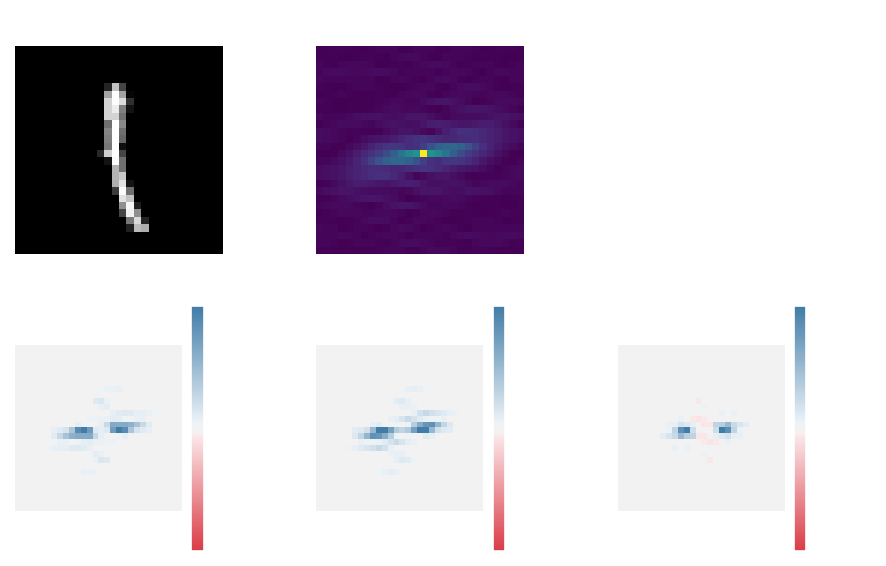

In [41]:
def signshow(x):
    max_abs = np.max(np.abs(x))
    plt.imshow(x, cmap=cm, vmin=-max_abs, vmax=max_abs)
    plt.colorbar()

R, C, = 2, 3
plt.figure(dpi=150)
plt.subplot(R, C, 1)
plt.imshow(im_orig, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(R, C, 2)
plt.imshow(fftshift(mag(im_f)))
plt.title('Original FFT')
plt.axis('off')

plt.subplot(R, C, C + 1)
signshow(attributions_ig)
plt.title('IG')
plt.axis('off')

plt.subplot(R, C, C + 2)
signshow(attributions_dl)
plt.title('DeepLift')
plt.axis('off')

plt.subplot(R, C, C + 3)
signshow(scores_cd[:, class_num].reshape(28, 28))
plt.title('CD')
plt.axis('off')

plt.tight_layout()
plt.show()

**scores in the image domain**

In [65]:
x.requires_grad = False
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(im_orig, fill=0, method='cd', sweep_dim=sweep_dim)
cd_scores_im = acd.get_scores_2d(model, method='cd', ims=tiles, im_torch=im_torch)

100%|██████████| 784/784 [00:08<00:00, 94.49it/s]


# cd transform score

100%|██████████| 120/120 [00:01<00:00, 70.14it/s]


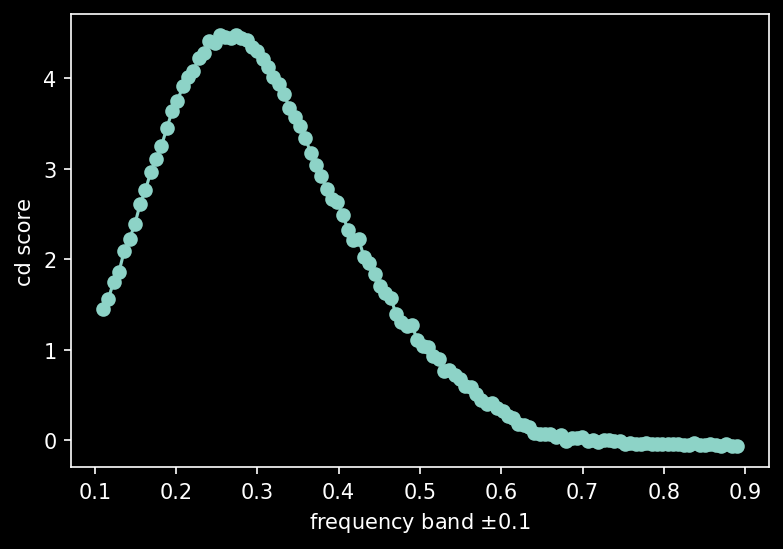

In [39]:
class_num = 1
scores = []
band_centers = np.linspace(0.11, 0.89, 120)
for band_center in tqdm(band_centers):
    score = acd.cd(im_torch, model, mask=None, model_type='mnist', device='cuda', 
                   transform=partial(bandpass_filter, band_center=band_center))[0].flatten()[class_num].item()
    scores.append(score)
    
# plot
plt.figure(dpi=150)
plt.plot(band_centers, scores, 'o-')
plt.xlabel('frequency band $\pm 0.1$')
plt.ylabel('cd score')
plt.show()    